In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting
from scipy.stats import chi2

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman
from mejiro.lenses import lens_util

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir
print(f'{pipeline_dir=}')

all_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=True, suppress_output=False)

pipeline_dir='/data/bwedig/mejiro/pipeline_dev'


  0%|          | 0/476 [00:00<?, ?it/s]

100%|██████████| 476/476 [00:03<00:00, 145.95it/s]


In [3]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass_dev')
filepaths = glob(os.path.join(save_dir, '*.pkl'))

ldsm_dict = {}
for fp in tqdm(filepaths):
    # get result
    result = util.unpickle(fp)

    # get uid
    basename = os.path.basename(fp)
    uid = basename.split('_')[1].split('.')[0]

    # build result dict
    result_dict = {}
    result_dict['lens'] = [l for l in all_lenses if l.uid == uid][0]
    result_dict['result'] = result
    ldsm_dict[uid] = result_dict

100%|██████████| 336/336 [00:02<00:00, 136.21it/s]


In [4]:
pval_threshold = 0.001  # three sigma

In [23]:
sides = 1
masses = np.linspace(1e7, 1e9, 100)

positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = Roman().divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

snr_list, theta_e_list, mu_list, mass_list = [], [], [], []
for uid, result_dict in ldsm_dict.items():
    result = result_dict['result']
    lens = result_dict['lens']

    mass_pos_list = []
    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                mass_pos_list.append(mass)
                break

    mass_med = np.median(mass_pos_list)
    if mass_med > 10**7:
        snr_list.append(lens.snr)
        theta_e_list.append(lens.get_einstein_radius())
        mu_list.append(lens.magnification)
        mass_list.append(mass_med)

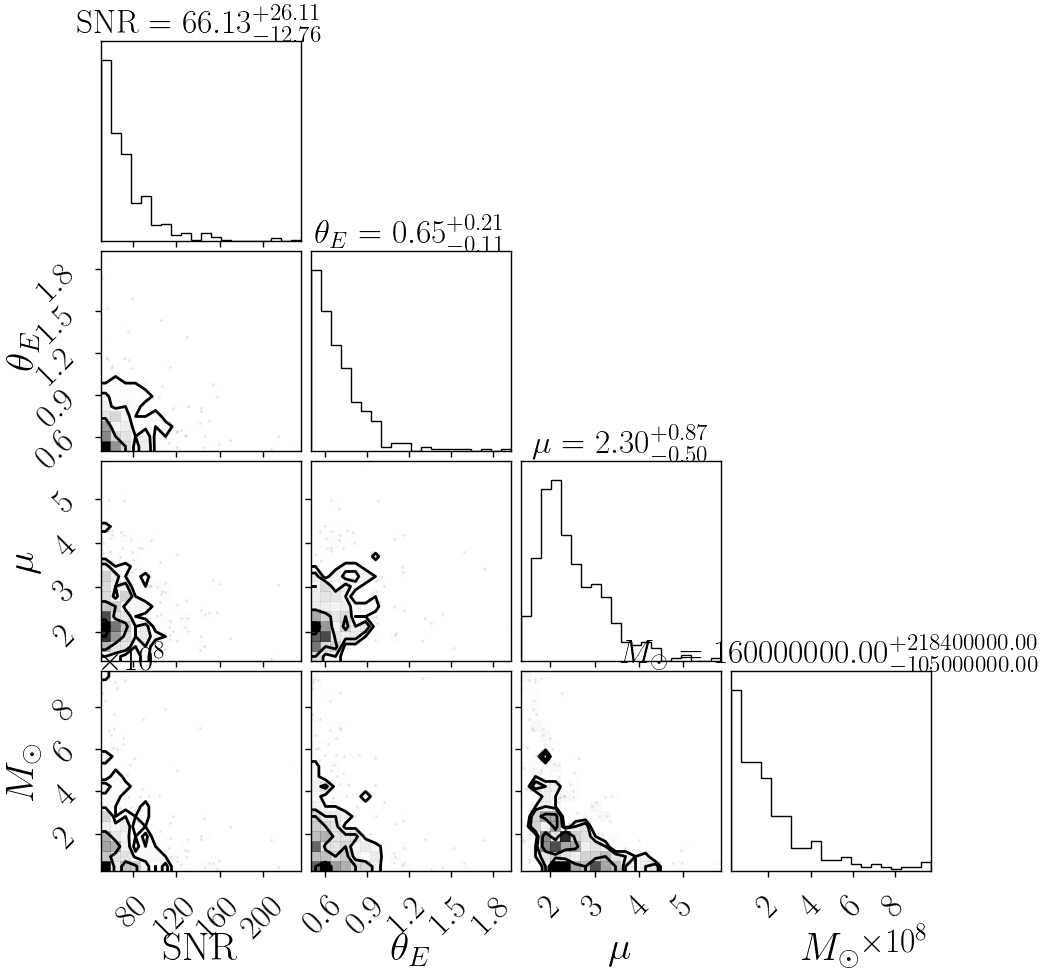

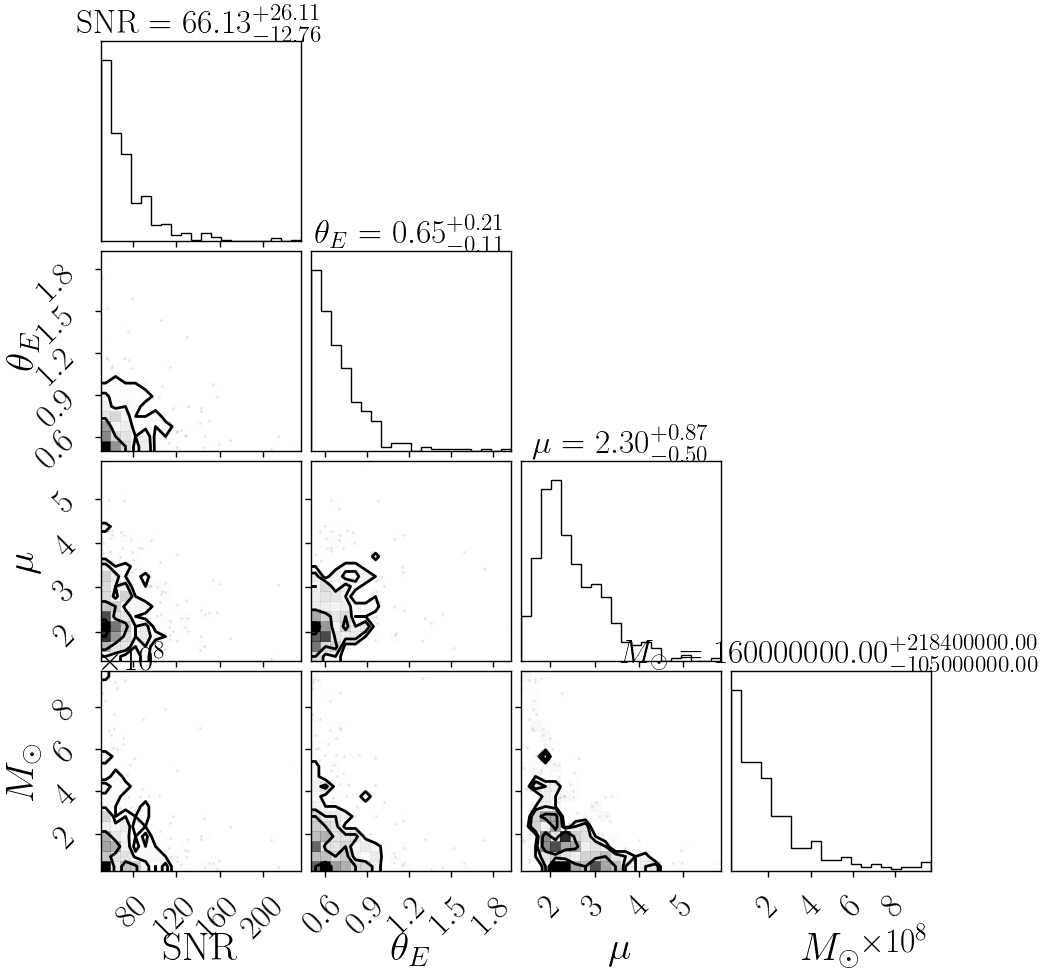

In [24]:
from corner import corner

corner_data = np.column_stack([snr_list, theta_e_list, mu_list, mass_list])

corner(corner_data, labels=['SNR', r'$\theta_E$', r'$\mu$', r'$M_{\odot}$'], show_titles=True)